# STORM 개념을 도입한 연구를 위한 멀티 에이전트

이 튜토리얼의 목적은 LangGraph를 활용하여 연구 자동화 시스템을 구축하는 방법에 대해서 다룹니다. 

연구는 종종 분석가에게 위임되는 노동 집약적인 작업입니다. AI는 이러한 연구 과정을 지원할 수 있는 상당한 잠재력을 가지고 있습니다. 이 튜토리얼에서는 사용자 맞춤형 AI 기반 연구 및 보고서 생성 워크플로우를 구축하는 방법을 다룹니다.

이번 튜토리얼에서는 경량의 다중 에이전트 시스템을 구축하여 연구 과정을 맞춤화하는 것을 목표로 합니다. 사용자는 연구 주제를 제공하고, 시스템은 각 하위 주제에 집중하는 AI 분석가 팀을 생성합니다. 

이 과정에서 `Human-in-the-loop`를 사용하여 연구가 시작되기 전에 하위 주제를 세분화합니다.

[STORM 논문](https://arxiv.org/abs/2402.14207)에 따르면, **유사한 주제 조회**와 **다양한 관점의 대화 시뮬레이션**을 통해 참고 출처 사용 빈도와 정보 밀도를 증가시킬 수 있습니다. 

**주로 다루는 내용**
- **LangGraph의 주요 테마**: Memory, Human-in-the-loop, Controllability
- **연구 자동화의 목표**: 사용자 맞춤형 연구 프로세스 구축
- **소스 선택**: 연구를 위한 입력 소스 선택
- **계획**: 주제 제공 및 AI 분석가 팀 생성
- **LLM 활용**: 전문가 AI와의 심층 인터뷰
- **연구 과정**: 병렬로 정보 수집 및 인터뷰 수행
- **출력 형식**: 최종 보고서로 통합된 통찰력
- **설정**: 환경 설정 및 API 키 설정
- **분석가 생성**: Human-In-The-Loop를 통한 분석가 생성 및 검토
- **인터뷰 수행**: 질문 생성 및 답변 수집
- **병렬 인터뷰**: Map-Reduce를 통한 인터뷰 병렬화
- **최종 보고서 작성**: 보고서의 서론 및 결론 작성

이번 튜토리얼에서는 다음의 세 가지 테마를 다룹니다.

- **Memory**
- **Human-in-the-loop**
- **Controllability**

이제 이러한 개념을 결합하여 AI의 가장 인기 있는 응용 분야 중 하나인 연구 자동화를 다루겠습니다. 

연구는 종종 분석가에게 위임되는 노동 집약적인 작업입니다. AI는 이러한 연구 과정을 지원할 수 있는 상당한 잠재력을 가지고 있습니다. 그러나 연구는 맞춤화가 필요합니다. 원시 LLM 출력은 실제 의사 결정 워크플로우에 적합하지 않은 경우가 많습니다.

맞춤형 AI 기반 [연구 및 보고서 생성](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) 워크플로우는 이를 해결할 수 있는 유망한 방법입니다.

![langgraph-storm-concept](./assets/langgraph-storm-concept.png)

## 환경 설정

In [33]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [34]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Use-Cases


In [35]:
from langchain_teddynote.models import get_model_name, LLMs
from langchain_openai import ChatOpenAI

# 최신 모델 가져오기
GPT4o = "gpt-4.1"

# 모델 초기화
llm = ChatOpenAI(model=GPT4o)

## 분석가 생성: Human-In-The-Loop

- **분석가 생성**: `Human-In-The-Loop`를 활용하여 분석가를 생성하고 검토합니다.

In [36]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_teddynote.graphs import visualize_graph


# 분석가의 속성과 메타데이터를 정의하는 클래스
class Analyst(BaseModel):
    # 주요 소속 정보
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    # 이름
    name: str = Field(description="Name of the analyst.")

    # 역할
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    # 중점, 우려 사항 및 동기에 대한 설명
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    # 분석가의 인적 정보를 문자열로 반환하는 속성
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# 분석가들의 집합
class Perspectives(BaseModel):
    # 분석가 목록
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

다음은 Analyst 클래스를 통해 생성된 분석가들의 집합을 추적하는 상태를 정의합니다.

In [37]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 사람 피드백
    human_analyst_feedback: str
    # 분석가 목록
    analysts: List[Analyst]

## 분석가(Analyst) 생성 노드 정의

다음으로는 분석가(Analyst) 생성 노드를 정의하겠습니다.

아래 코드는 주어진 연구 주제에 대해 다양한 분석가를 생성하는 로직을 구현합니다. 각 분석가는 고유한 역할과 소속을 가지며, 주제에 대한 전문적인 관점을 제공합니다.

In [38]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage

# 분석가 생성 프롬프트
analyst_instructions = """You are tasked with creating a set of AI analyst personas.

Follow these instructions carefully:
1. First, review the research topic:

{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성하는 함수"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # LLM에 구조화된 출력 형식을 적용
    structured_llm = llm.with_structured_output(Perspectives)

    # 분석가 생성을 위한 시스템 프롬프트 구성
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # LLM을 호출하여 분석가 페르소나 생성
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    # 생성된 분석가 목록을 상태에 저장
    return {"analysts": analysts.analysts}


# 사용자 피드백 노드(상태 업데이트를 진행할 예정이므로, 내용은 비워 두어도 무방)
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass


# 인간 피드백 여부에 따라 워크플로우의 다음 단계를 결정하는 함수
def should_continue(state: GenerateAnalystsState):
    """워크플로우의 다음 단계를 결정하는 함수"""

    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

## 그래프 생성

이제 분석가 생성 그래프를 생성합니다.

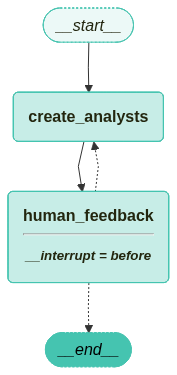

In [39]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

# 그래프 생성
builder = StateGraph(GenerateAnalystsState)

# 노드 추가
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

# 엣지 연결
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")

# 조건부 엣지 추가: 사람 피드백이 있을 경우 다시 분석가 생성 노드로 돌아갑니다.
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# 메모리 생성
memory = MemorySaver()

# 그래프 컴파일(중단점 설정)
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# 그래프 시각화
visualize_graph(graph)

## 분석가 생성을 위한 그래프 실행

In [40]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

# 분석가 수 설정
max_analysts = 3

# 연구 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 입력 데이터 설정
inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='AI Infrastructure Research Lab' name='Dr. Yuna Kim' role='Architectural Analyst' description='Dr. Kim focuses on the technical distinctions between Modular RAG and Naive RAG, analyzing how architectural changes lead to performance and scalability differences. Her main concern is how modularization impacts flexibility, maintainability, and integration with other production systems.'
affiliation='Enterprise AI Solutions, Inc.' name='Eliot Park' role='Production Deployment Strategist' description='Eliot specializes in bringing AI models, especially Retrieval Augmented Generation systems, into production environments. His perspective centers around the operational and business advantages of Modular RAG—such as reliability, efficiency, ease of scaling, and rapid adaptation to changing requirements—in comparison to Naive RAG.'
affiliation='SecureTech Analytics' name='Ava Lee' role='Risk and Compliance 

In [41]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

# 분석가 수 설정
max_analysts = 3

# 연구 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 입력 데이터 설정
inputs = {
    "topic": topic,
    "max_analysts": max_analysts,
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"analysts":[{"affiliation":"Enterprise AI Consultant, DataEdge Solutions","name":"Dr. Min-jun Park","role":"Scalability & Architecture Specialist","description":"Dr. Park examines the architectural distinctions between Modular RAG and Naive RAG, focusing on their respective approaches to retrieval granularity, modularity, and extensibility. His primary concern is understanding how the modular design improves flexibility, maintainability, and the ease of integrating new data sources in large-scale enterprise implementations."},{"affiliation":"Machine Learning Product Lead, HyperNLP","name":"Soo-yeon Kim","role":"Production Deployment Strategist","description":"Soo-yeon Kim investigates the advantages of Modular RAG over Naive RAG in real-world, production-level use cases. Her focus is on system robustness, operational efficiency, fault tolerance, and the capacity for independent module updates, all crucial fo

`__interrupt__` 가 출력되면 인간의 피드백을 받을 준비가 된 것입니다.

이제 아래의 상태를 가져와서 인간 피드백을 제공합니다.

In [42]:
# 그래프의 현재 상태 가져오기
state = graph.get_state(config)

# 다음 실행할 노드 확인
print(state.next)

('human_feedback',)


`update_state()` 를 통해 인간 피드백을 주입합니다. 이때 `human_analyst_feedback` 키에 피드백 내용을 저장합니다.

또한 `as_node` 인자를 통해 피드백을 받을 노드를 지정합니다.

In [43]:
# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config,
    {
        "human_analyst_feedback": "Add in someone named Teddy Lee from a startup to add an entrepreneur perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '37c11b5d-9b0c-435b-b89a-026ee3039a13',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab197-0127-64ca-8002-04eac471abd9'}}

`None` 값을 입력으로 주게 되면, 이어서 그래프가 진행됩니다.

**참고**

- 재개하고자 할 때는 입력에 `None` 값을 할당하여 그래프를 재개합니다.

In [44]:
# 이어서 진행
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Stanford University, Department of Computer Science' name='Dr. Lilian Park' role='AI Researcher and RAG Methodology Specialist' description='Dr. Park focuses on the technical evolution of Retrieval-Augmented Generation (RAG) methods. Her work dissects the architectural improvements brought by modular RAG over naive RAG, analyzing the implications for scalability, maintainability, and the integration of domain-specific modules.'
affiliation='GAFA (Global Enterprise Technology Integrator)' name='Michael Grant' role='Enterprise AI Solutions Architect' description='Michael specializes in deploying large-scale AI solutions in enterprise settings. His primary concern is the production-readiness of RAG systems, with an emphasis on reliability, operational efficiency, and how modular architectures facilitate smoother production deployments compared to naive approaches.'
affiliation='AlpinaAI (Startup Fou

다시 `__interrupt__` 가 출력되면 인간의 피드백을 받을 준비가 된 것입니다.

이전의 방식과 동일하게 다시 인간 피드백을 제공하여 생성된 분석가의 페르소나를 조정하는 것도 가능합니다.

하지만, 추가 피드백이 없을 경우 `None` 값을 할당하여 분석가 생성 작업을 종료할 수 있습니다.

In [45]:
# 추가 피드백이 없을 경우 None 값을 할당하여 상태 업데이트
human_feedback_input = None

# 그래프 상태를 업데이트하여 human_feedback 노드의 역할 수행
graph.update_state(
    config, {"human_analyst_feedback": human_feedback_input}, as_node="human_feedback"
)

{'configurable': {'thread_id': '37c11b5d-9b0c-435b-b89a-026ee3039a13',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab197-4734-681e-8004-41d6e9d3d365'}}

In [46]:
# 이어서 진행
invoke_graph(graph, None, config)

최종 결과를 출력합니다.

In [47]:
# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 상태에서 생성된 분석가 목록 가져오기
analysts = final_state.values.get("analysts")

# 생성된 분석가 수 출력
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

# 각 분석가의 페르소나 출력
for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

생성된 분석가 수: 3
Name: Dr. Lilian Park
Role: AI Researcher and RAG Methodology Specialist
Affiliation: Stanford University, Department of Computer Science
Description: Dr. Park focuses on the technical evolution of Retrieval-Augmented Generation (RAG) methods. Her work dissects the architectural improvements brought by modular RAG over naive RAG, analyzing the implications for scalability, maintainability, and the integration of domain-specific modules.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Name: Michael Grant
Role: Enterprise AI Solutions Architect
Affiliation: GAFA (Global Enterprise Technology Integrator)
Description: Michael specializes in deploying large-scale AI solutions in enterprise settings. His primary concern is the production-readiness of RAG systems, with an emphasis on reliability, operational efficiency, and how modular architectures facilitate smoother production deployments compared to naive approaches.

- - - - - - - - - - - - - - - - - - - - - - 

`final_state.next` 는 그래프의 다음 실행할 노드를 나타냅니다. 여기서는 모든 작업이 마무리 되었기 때문에 빈 `tuple` 이 출력됩니다.

In [48]:
# 그래프의 다음 실행할 노드 상태 가져오기
print(final_state.next)

()


## 인터뷰 수행

### 질문 생성

- 분석가는 전문가에게 질문을 제시합니다.

In [49]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


# 인터뷰 상태 정의
class InterviewState(MessagesState):
    # 대화 턴수
    max_num_turns: int
    # 소스 문서를 포함하는 컨텍스트 리스트
    context: Annotated[list, operator.add]
    # 지정된 분석가
    analyst: Analyst
    # 인터뷰 내용을 저장하는 문자열
    interview: str
    # 보고서 섹션 리스트
    sections: list


# 검색 쿼리 데이터 클래스 정의
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

다음으로는 인터뷰 질문을 생성하는 노드를 정의합니다.

In [50]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


# 질문을 생성하는 노드 정의
def generate_question(state: InterviewState):
    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]

    # 질문 생성
    # 분석가의 목표를 기반으로 시스템 메시지 생성
    system_message = question_instructions.format(goals=analyst.persona)
    # LLM을 사용하여 질문 생성
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 상태에 메시지 기록
    return {"messages": [question]}

## 도구 정의

전문가는 여러 소스로부터 정보를 병렬로 수집하여 질문에 답변합니다.

웹 문서 스크래핑, VectorDB, 웹 검색, 위키피디아 검색 등 다양한 도구를 사용할 수 있습니다.

이 튜토리얼에서는 Arxiv, Tavily 검색을 사용합니다.

In [51]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색을 위한 TavilySearch 인스턴스 생성
tavily_search = TavilySearch(max_results=3)

In [52]:
from langchain_community.retrievers import ArxivRetriever

# Arxiv 검색을 위한 ArxivRetriever 인스턴스 생성
arxiv_retriever = ArxivRetriever(
    load_max_docs=3,
    load_all_available_meta=True,
    get_full_documents=True,
)

# 검색 결과 출력
arxiv_search_results = arxiv_retriever.invoke("Modular RAG vs Naive RAG")
print(arxiv_search_results)

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

In [53]:
# Arxiv 메타데이터 출력
arxiv_search_results[0].metadata

{'Published': '2024-07-26',
 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks',
 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang',
 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a highly reconfigurabl

In [54]:
# Arxiv 내용 출력
print(arxiv_search_results[0].page_content)

1
Modular RAG: Transforming RAG Systems into
LEGO-like Reconfigurable Frameworks
Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang
Abstract—Retrieval-augmented
Generation
(RAG)
has
markedly enhanced the capabilities of Large Language Models
(LLMs) in tackling knowledge-intensive tasks. The increasing
demands of application scenarios have driven the evolution
of RAG, leading to the integration of advanced retrievers,
LLMs and other complementary technologies, which in turn
has amplified the intricacy of RAG systems. However, the rapid
advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process
of “retrieve-then-generate”. In this context, this paper examines
the limitations of the existing RAG paradigm and introduces
the modular RAG framework. By decomposing complex RAG
systems into independent modules and specialized operators, it
facilitates a highly reconfigurable framework. Modular RAG
transcends the traditional linear architect

문서 검색결과를 포맷팅 출력합니다.

In [55]:
# 문서 검색 결과를 포맷팅
formatted_search_docs = "\n\n---\n\n".join(
    [
        f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in arxiv_search_results
    ]
)

In [56]:
print(formatted_search_docs)

<Document source="http://arxiv.org/abs/2407.21059v1" date="2024-07-26" authors="Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang"/>
<Title>
Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks
</Title>

<Summary>
Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities
of Large Language Models (LLMs) in tackling knowledge-intensive tasks. The
increasing demands of application scenarios have driven the evolution of RAG,
leading to the integration of advanced retrievers, LLMs and other complementary
technologies, which in turn has amplified the intricacy of RAG systems.
However, the rapid advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process of
"retrieve-then-generate". In this context, this paper examines the limitations
of the existing RAG paradigm and introduces the modular RAG framework. By
decomposing complex RAG systems into independent modules and specialized
operators, it fa

## 노드 생성


In [57]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# 검색 쿼리 작성
search_instructions = SystemMessage(
    content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""
)


# 웹 검색 수행 함수 정의
def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""

    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # 검색 수행
    search_docs = tavily_search.invoke(search_query.search_query)

    # 검색 결과 형식 지정
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


# Arxiv 검색 노드 생성
def search_arxiv(state: InterviewState):
    """Arxiv 검색 노드"""

    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    try:
        # 검색 수행
        arxiv_search_results = arxiv_retriever.invoke(
            search_query.search_query,
            load_max_docs=2,
            load_all_available_meta=True,
            get_full_documents=True,
        )

        # 검색 결과 형식 지정
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
                for doc in arxiv_search_results
            ]
        )

        return {"context": [formatted_search_docs]}
    except Exception as e:
        print(f"Arxiv 검색 중 오류 발생: {str(e)}")
        return {
            "context": ["<Error>Arxiv 검색 결과를 가져오는데 실패했습니다.</Error>"]
        }


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""


# 질문에 대한 답변 생성 함수 정의
def generate_answer(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 분석가와 메시지 가져오기
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # 질문에 대한 답변 생성
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 메시지를 전문가의 답변으로 명명
    answer.name = "expert"

    # 상태에 메시지 추가
    return {"messages": [answer]}


# 인터뷰 저장 함수 정의
def save_interview(state: InterviewState):
    """인터뷰 저장"""

    # 메시지 가져오기
    messages = state["messages"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(messages)

    # 인터뷰 키에 저장
    return {"interview": interview}


# 메시지 라우팅 함수 정의
def route_messages(state: InterviewState, name: str = "expert"):
    """질문과 답변 사이의 라우팅"""

    # 메시지 가져오기
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # 전문가의 답변 수 확인
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 전문가가 최대 턴 수 이상 답변한 경우 종료
    if num_responses >= max_num_turns:
        return "save_interview"

    # 이 라우터는 각 질문-답변 쌍 후에 실행됨
    # 논의 종료를 신호하는 마지막 질문 가져오기
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"


# 세션 작성 지시사항
section_writer_instructions = """You are an expert technical writer.

Your task is to create a detailed and comprehensive section of a report, thoroughly analyzing a set of source documents.
This involves extracting key insights, elaborating on relevant points, and providing in-depth explanations to ensure clarity and understanding. Your writing should include necessary context, supporting evidence, and examples to enhance the reader's comprehension. Maintain a logical and well-organized structure, ensuring that all critical aspects are covered in detail and presented in a professional tone.

Please follow these instructions:
1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Comprehensive analysis (### header)
d. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. For the Comprehensive analysis section:
- Provide a detailed examination of the information from the source documents.
- Break down complex ideas into digestible segments, ensuring a logical flow of ideas.
- Use sub-sections where necessary to cover multiple perspectives or dimensions of the analysis.
- Support your analysis with data, direct quotes, and examples from the source documents.
- Clearly explain the relevance of each point to the overall focus of the report.
- Use bullet points or numbered lists for clarity when presenting multiple related ideas.
- Ensure the tone remains professional and objective, avoiding bias or unsupported opinions.
- Aim for at least 800 words to ensure the analysis is thorough.

7. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

8. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

9. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


# 섹션 작성 함수 정의
def write_section(state: InterviewState):
    """질문에 대한 답변 생성 노드"""

    # 상태에서 컨텍스트, 분석가 가져오기
    context = state["context"]
    analyst = state["analyst"]

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # 상태에 섹션 추가
    return {"sections": [section.content]}

## 인터뷰 그래프 생성

인터뷰를 수행하는 그래프를 정의하고 실행합니다.

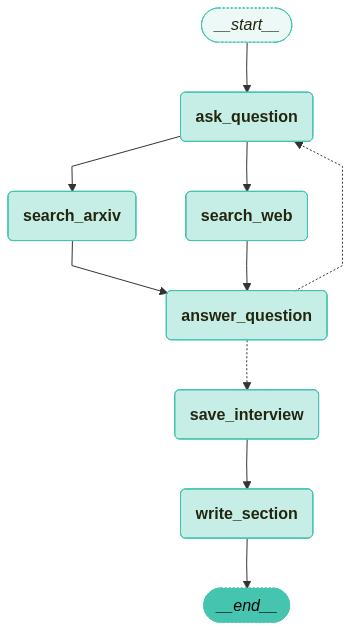

In [58]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 노드 및 엣지 추가
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_arxiv", search_arxiv)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# 흐름 설정
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_arxiv")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_arxiv", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# 인터뷰 그래프 생성
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# 그래프 시각화
visualize_graph(interview_graph)

In [59]:
# 분석가 목록에서 첫 번째 분석가 선택
analysts[0]

Analyst(affiliation='Stanford University, Department of Computer Science', name='Dr. Lilian Park', role='AI Researcher and RAG Methodology Specialist', description='Dr. Park focuses on the technical evolution of Retrieval-Augmented Generation (RAG) methods. Her work dissects the architectural improvements brought by modular RAG over naive RAG, analyzing the implications for scalability, maintainability, and the integration of domain-specific modules.')

## 그래프 실행

이제 그래프를 실행하고 결과를 출력합니다.

In [60]:
from IPython.display import Markdown

# 주제 설정
topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 인터뷰 시작 메시지 생성
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# 스레드 ID 설정
config = RunnableConfig(
    recursion_limit=100,
    configurable={"thread_id": random_uuid()},
)

# 그래프 실행
invoke_graph(
    interview_graph,
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 5},
    config,
)


🔄 Node: ask_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

안녕하세요, 저는 기술 전문 매체의 데이터 기자인 민지 아이라고 합니다. 오늘 Modular RAG와 Naive RAG의 차이, 그리고 실무에서 Modular RAG를 사용할 때 구체적으로 어떤 이점이 있는지 여쭤보고 싶어서 인터뷰를 요청드렸습니다.

첫 질문부터 드리자면, "Naive RAG"가 기본적으로 단일 검색기(retriever)와 생성기(generator)를 연결한 구조로 알려져 있는데, Dr. Park께서 Modular RAG를 연구하시며 보신 뚜렷한 구조적 차이나 개선점은 어떤 것들이 있을까요? 실제로 어떤 식으로 모듈화가 이루어지는지, 예시를 들어 설명해주실 수 있을까요?

🔄 Node: search_web 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<Document href="https://www.ibm.com/think/topics/rag-techniques"/>
While naive RAG is straightforward and quick, modular RAG—often built with frameworks such as LangChain—provides enhanced flexibility, scalability and
</Document>

---

<Document href="https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/"/>
Naive RAG, the initial implementation of Retrieval-Augmented Generation, operates on a straightforward principle: retr

마크다운 형식으로 결과를 출력합니다.

In [61]:
# 완성된 인터뷰 섹션 출력
Markdown(interview_graph.get_state(config).values["sections"][0])

## Unpacking the Technical Evolution of RAG: From Naive to Modular Architectures

### Summary

Retrieval-Augmented Generation (RAG) methods have rapidly emerged as transformative solutions to key limitations in Large Language Models (LLMs), notably hallucinations, knowledge gaps, and challenges in domain adaptation. However, the field is currently witnessing a fundamental shift: the move from "naive" linear RAG architectures—where retrieval and generation occur as a monolith—to modular, reconfigurable frameworks designed for scalability, maintainability, and sophisticated domain-specific integration. This modularization trend is central to addressing the growing intricacies of RAG deployments in real-world, knowledge-intensive, and safety-critical scenarios.

The core findings from the literature reveal several novel and crucial insights:
- **Naive RAG architectures, while effective in many scenarios, face significant limitations when queries become complex, non-linear, or highly domain-specific.** These challenges stem from shallow query understanding, noisy retrieval, and the lack of fine-grained control over data flow and processing logic.
- **Modular RAG represents a paradigm shift**, breaking the monolithic pipeline into independently engineered and interchangeable modules (“LEGO-like” components). This enables fine-tuned retrieval, adaptive reasoning schemes (e.g., routing, scheduling, fusion), and seamless integration of both generic and domain-specific operators.
- **State-of-the-art analysis identifies not only technical components but also common design patterns for modular RAGs:** linear, conditional, branching, and looping architectures, each suited to particular classes of tasks.
- **Modular RAG frameworks establish a practical and theoretical foundation** that can handle the rapidly increasing demands of diverse knowledge domains, complex reasoning requirements, and evolving evaluation protocols.

Key sources for this synthesis:
1. Gao, Y., Xiong, Y., Wang, M., & Wang, H. (2024). "Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks" [arXiv:2407.21059v1].
2. Gao, Y., Xiong, Y., Gao, X. et al. (2024). "Retrieval-Augmented Generation for Large Language Models: A Survey" [arXiv:2312.10997v5].
3. Adasci.org article ("How does modular RAG improve upon naive RAG?").
4. Blog posts and technical documentation on modular RAG architectures from IBM, MeiliSearch, and implementation case-studies.

Collectively, these analyses challenge longstanding design assumptions and point to a future where RAG systems are not merely pipelines, but robust, composable frameworks capable of meeting the demands of next-generation AI applications.

### Comprehensive Analysis

#### 1. The Foundations and Shortcomings of Naive RAG

**Linear and Monolithic Architecture**
Naive RAG, as articulated in the foundational literature, operates on a straightforward pipeline: a user query is mapped into an embedding space, used for static retrieval from an external knowledge base, and the results are then concatenated with the original prompt for an LLM to generate a response ([1], [2], [3]). Key elements include:
- *Indexing* of external data into a vector store;
- *Retrieval* based solely on (usually) vector space similarity to the user's query;
- *Generation* by the LLM using retrieved text fragments as context ([2]).

**Primary Limitations:**
- **Shallow Query Understanding:** Naive similarity measures do not robustly capture complex relationships between queries and documents ([1], [3]). For instance, queries requiring non-obvious inference or multi-hop reasoning often see performance drop-offs.
- **Retrieval Redundancy and Noise:** As observed in both research and practitioner-oriented reports ([1], [2]), returning many loosely relevant or redundant chunks introduces confusion and increases the risk of hallucinations in LLM outputs.
- *Lack of Process Flexibility:* The entire process is monolithic—new features (e.g., advanced filtering, reasoning steps, or new retrieval strategies) are difficult to introduce without major system overhauls.

#### 2. The Emergence of Modular RAG

**Concept and Motivation**
Driven by advancing application demands, modular RAG decomposes the pipeline into smaller, independently maintained modules (retrievers, generators, rerankers, memory units, evaluators, etc.) ([1], [3], [4]). This modularization allows for:
- **Plug-and-play of specialized modules,** enabling rapid iteration and integration of new research advances (e.g., fusion of different retrievers, advanced chunkers, or expert systems).
- **Custom operator definition** (routing, scheduling, fusion, summarization, etc.), allowing the architecture to adapt dynamically to query and domain characteristics.

**Key Technical Innovations:**
- **Routing and Scheduling:** Instead of a static pipeline, modular RAG employs intelligent decision-making (often using agentic or policy-based systems) to route queries to the most apt retrieval and reasoning paths ([1]).
- **Fusion and Aggregation:** The combinatorial assembly of knowledge from multiple relevant sources, rather than simplistic concatenation ([1], [4]). For example, complex queries triggering branch or loop patterns allow for evidence gathering, iterative refinement, or multi-stage synthesis.
- **Operator Flexibility:** New operators such as conditional execution, iterative revision, and domain adaptation modules can be incorporated as needed, supporting advanced reasoning and knowledge fusion.

**Prevailing Modular Patterns**
Gao et al. ([1]) identify four prominent patterns:
- *Linear:* Sequential retrieval and generation, akin to naive RAG, but with replaceable modules.
- *Conditional:* Branches based on intermediate decision logic (e.g., type of query, detected ambiguity).
- *Branching:* Parallel retrieval/generation across multiple paths, suitable for complex or uncertain queries.
- *Looping:* Iterative refinement, supporting multi-step reasoning or dynamic clarification.

#### 3. Implications for Scalability, Maintainability, and Domain Integration

##### a) Scalability
- **Module Isolation:** Modular RAG allows the distribution of computation across multiple, specialized modules, supporting parallelization and elastic scaling ([1], [4]).
- **Upgradable Components:** New algorithms (e.g., dense retrievers, semantic rerankers, advanced chunkers) can be swapped in with minimal disruption—a marked advance over naive RAG systems ([1], [3]).

##### b) Maintainability
- **Simplified Testing and Debugging:** With discrete module boundaries, errors and bottlenecks can be isolated and addressed efficiently.
- **Standardized Interfaces:** Adoption of inter-module communication standards allows integration of heterogeneous tools and future technologies, keeping systems maintainable as they grow in complexity ([3], [4]).

##### c) Domain-Specific Integration
- **Custom Embedding and Retrieval:** Domain adaptation is attainable by fine-tuning specific modules—such as retrievers or rerankers—on domain-relevant datasets without impacting the broader pipeline ([2]).
- **Seamless Knowledge Base Expansion:** New sources can be appended, and corresponding retrievers/filters can be tailored or swapped in without pipeline reengineering ([1], [2]).
- **Domain Operators:** For example, in medical or legal use-cases, domain-specific post-processing, reasoning, or compliance-check operators can be added modularly ([1], [3]).

#### 4. Modular RAG as a Foundation for Rapid Innovation

Modular RAG is not simply a theoretical advance; it provides a *practical roadmap* for building next-generation RAG systems. Several sources ([1], [3], [4]) highlight:
- **Compatibility with emerging evaluation standards:** As benchmarking and test frameworks evolve, modular RAG frameworks can incorporate new evaluation modules for continuous improvement.
- **Support for new paradigms:** As new reasoning schemes (e.g., multi-agent frameworks, dynamic plan generation, self-refining pipelines) appear, modular RAG's architecture is uniquely suited to absorbing these advances.
- **Production-readiness:** Industry implementation guidelines (IBM, MeiliSearch, open frameworks) combine modular RAG with observability, feedback loops, and developer-centric design, bridging research and business requirements ([4]).

#### 5. Theoretical and Practical Significance

- **Theoretically,** modular RAG lays the groundwork for a unified RAG "technology tree"—as described by Gao et al. ([2])—wherein various architectures, reasoning mechanisms, and domain adaptations are composable and extendable on demand.
- **Practically,** organizations gain the flexibility to respond to changing domain knowledge, regulations, or system requirements without rebuilding entire pipelines. This ensures that LLM-based systems remain current, reliable, and robust as both user expectations and knowledge bases evolve.

### Sources

[1] http://arxiv.org/abs/2407.21059v1  
[2] http://arxiv.org/abs/2312.10997v5  
[3] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[4] https://www.meilisearch.com/blog/modular-rag  
[5] https://www.ibm.com/think/topics/rag-techniques

In [62]:
print(interview_graph.get_state(config).values["sections"][0])

## Unpacking the Technical Evolution of RAG: From Naive to Modular Architectures

### Summary

Retrieval-Augmented Generation (RAG) methods have rapidly emerged as transformative solutions to key limitations in Large Language Models (LLMs), notably hallucinations, knowledge gaps, and challenges in domain adaptation. However, the field is currently witnessing a fundamental shift: the move from "naive" linear RAG architectures—where retrieval and generation occur as a monolith—to modular, reconfigurable frameworks designed for scalability, maintainability, and sophisticated domain-specific integration. This modularization trend is central to addressing the growing intricacies of RAG deployments in real-world, knowledge-intensive, and safety-critical scenarios.

The core findings from the literature reveal several novel and crucial insights:
- **Naive RAG architectures, while effective in many scenarios, face significant limitations when queries become complex, non-linear, or highly domai

## 인터뷰를 병렬로 진행 (map-reduce)

- 인터뷰는 langgraph 의 `Send()` 함수를 사용하여 병렬화하며, 이는 `map` 단계에 해당합니다.
- 인터뷰 결과는 `reduce` 단계에서 보고서 본문에 통합됩니다.
- 최종 보고서에 서론과 결론을 작성하는 마지막 단계를 추가합니다.

In [63]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


# ResearchGraphState 상태 정의
class ResearchGraphState(TypedDict):
    # 연구 주제
    topic: str
    # 생성할 분석가의 최대 수
    max_analysts: int
    # 인간 분석가의 피드백
    human_analyst_feedback: str
    # 질문을 하는 분석가 목록
    analysts: List[Analyst]
    # Send() API 키를 포함하는 섹션 리스트
    sections: Annotated[list, operator.add]
    # 최종 보고서의 서론
    introduction: str
    # 최종 보고서의 본문 내용
    content: str
    # 최종 보고서의 결론
    conclusion: str
    # 최종 보고서
    final_report: str

### LangGraph 의 Send() 함수 사용

아래는 langgraph 의 `Send()` 함수를 사용하여 인터뷰를 병렬로 시작하는 함수입니다.

**참고**

- [LangGraph Send()](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)

In [64]:
from langgraph.constants import Send


# 모든 인터뷰를 시작
def initiate_all_interviews(state: ResearchGraphState):
    # 사람의 피드백 확인
    human_analyst_feedback = state.get("human_analyst_feedback")

    # 만약, 사람의 피드백이 있으면 분석가 생성으로 돌아가기
    if human_analyst_feedback:
        return "create_analysts"

    # 그렇지 않으면 Send() 함수를 통해 인터뷰 병렬로 시작
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]

/var/folders/hc/ll05l0gj6cl27x40w2r115kh0000gn/T/ipykernel_44789/3516655113.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


### 보고서 작성 정의

다음은 인터뷰 내용을 바탕으로 보고서 작성 가이드라인을 정의하고 보고서 작성 함수를 정의합니다.

In [65]:
# 보고서 작성 지시사항
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Carefully review and analyze the insights from each memo.
3. Consolidate these insights into a detailed and comprehensive summary that integrates the central ideas from all the memos.
4. Organize the key points from each memo into the appropriate sections provided below, ensuring that each section is logical and well-structured.
5. Include all required sections in your report, using `### Section Name` as the header for each.
6. Aim for approximately 250 words per section, providing in-depth explanations, context, and supporting details.

**Sections to consider (including optional ones for greater depth):**

- **Background**: Theoretical foundations, key concepts, and preliminary information necessary to understand the methodology and results.
- **Related Work**: Overview of prior studies and how they compare or relate to the current research.
- **Problem Definition**: A formal and precise definition of the research question or problem the paper aims to address.
- **Methodology (or Methods)**: Detailed description of the methods, algorithms, models, data collection processes, or experimental setups used in the study.
- **Implementation Details**: Practical details of how the methods or models were implemented, including software frameworks, computational resources, or parameter settings.
- **Experiments**: Explanation of experimental protocols, datasets, evaluation metrics, procedures, and configurations employed to validate the methods.
- **Results**: Presentation of experimental outcomes, often with statistical tables, graphs, figures, or qualitative analyses.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


# 보고서 작성 함수 정의
def write_report(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 최종 보고서 작성
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Write a report based upon these memos.")]
    )
    return {"content": report.content}


# 서론과 결론 작성 지시사항
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 200 words, crisply previewing (for introduction),  or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


# 서론 작성 함수 정의
def write_introduction(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 서론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report introduction")]
    )
    return {"introduction": intro.content}


# 결론 작성 함수 정의
def write_conclusion(state: ResearchGraphState):
    # 모든 섹션 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 연결
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션을 요약하여 결론 작성
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report conclusion")]
    )
    return {"conclusion": conclusion.content}


# 최종 보고서 작성 함수 정의
def finalize_report(state: ResearchGraphState):
    # 모든 섹션을 모아 최종 보고서 작성
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n## Main Idea\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

## 그래프 정의

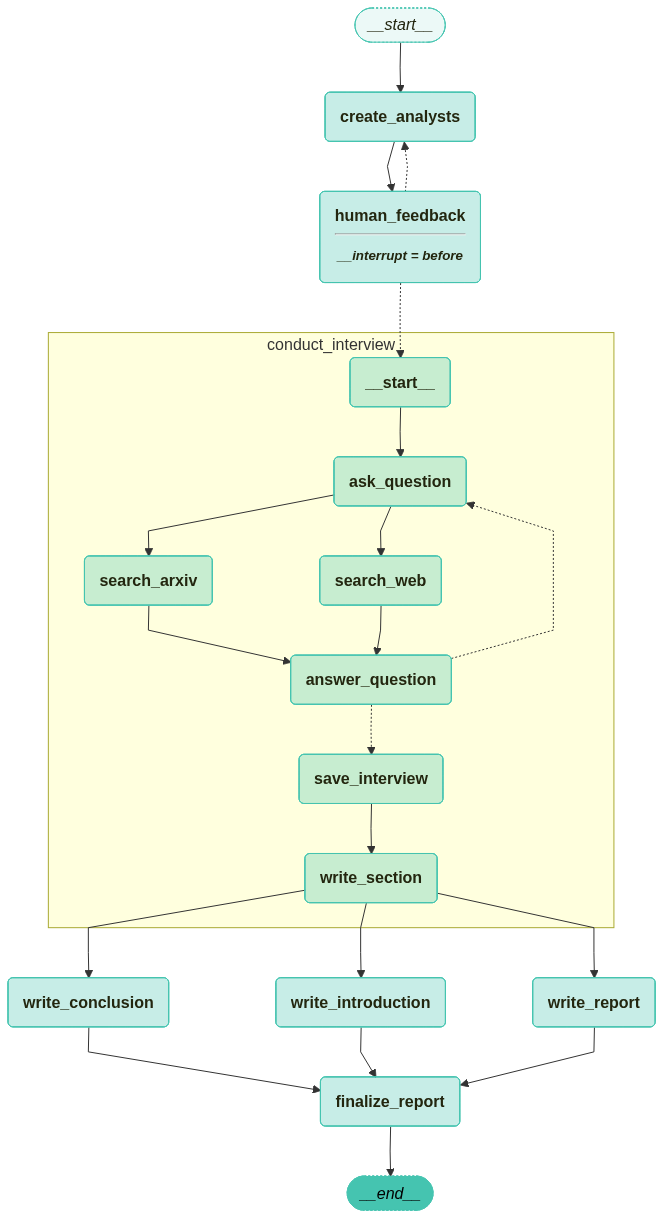

In [66]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START, END
from langchain_teddynote.graphs import visualize_graph

# 그래프 생성
builder = StateGraph(ResearchGraphState)

# 노드 정의
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 엣지 정의
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)

# 인터뷰 결과 보고서 작성
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# 보고서 최종 정리
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# 컴파일
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

visualize_graph(graph, xray=True)

## 그래프 실행

이제 그래프를 실행하고 결과를 확인합니다.

`max_analysts`, `topic` 을 자유롭게 변경하여 실행해 보세요.

In [67]:
# 입력 데이터 설정
max_analysts = 3
topic = "Explain how Modular RAG differs from traditional Naive RAG and the benefits of using it at the production level."

# config 설정
config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random_uuid()},
)

# 입력 데이터 설정
inputs = {"topic": topic, "max_analysts": max_analysts}

# 그래프 실행: 첫 번째 중단 지점까지
invoke_graph(graph, inputs, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='Enterprise MLOps Consultancy' name='Dr. Priya Nair' role='Production Systems Architect' description='Focuses on deployment challenges and scalability of AI solutions in enterprise contexts. Examines how Modular RAG impacts observability, maintainability, and long-term ROI compared to Naive RAG, with particular attention to upgradability and A/B testing in production workflows.'
affiliation='Academic AI Research Lab' name='Prof. Julian Beck' role='Framework Theorist' description='Explores the theoretical distinctions between Modular and Naive RAG architectures. Interested in composability, modularity, and experimental evidence for how modular systems enable more robust innovation and error isolation in applied retrieval-augmented generation systems.'
affiliation='Cloud AI Platform Provider' name='Jessica Wu' role='Product Reliability Lead' description='Prioritizes reliability, performance, and ope

human_feedback 을 추가하여 분석가를 설정합니다.

In [68]:
# 새로운 분석가 추가
graph.update_state(
    config,
    {"human_analyst_feedback": "Add Prof. Jeffrey Hinton as a head of AI analyst"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': 'ce3e045b-da78-492d-ad86-6eb1c6fee521',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab19c-b307-61c2-8002-1f4b98bfd934'}}

In [69]:
# 그래프 실행
invoke_graph(graph, None, config)


🔄 Node: create_analysts 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
affiliation='University of Toronto / Vector Institute' name='Prof. Geoffrey Hinton' role='Head AI Analyst' description='Renowned pioneer in deep learning, Prof. Hinton evaluates the conceptual advancements from Naive RAG to Modular RAG, focusing on architectural innovations and their implications for retrieval-augmented generation (RAG) systems.'
affiliation='OpenAI' name='Dr. Priya Sarin' role='Scalability and Production Expert' description='Dr. Sarin analyzes the production-scale benefits of Modular RAG, particularly around scalability, maintainability, and system robustness in real-world deployment settings.'
affiliation='Google DeepMind' name='Dr. Miguel Alvarez' role='Evaluation and Performance Analyst' description='Dr. Alvarez investigates the empirical performance improvements and fine-tuning opportunities enabled by Modular RAG, comparing it with traditional approaches and emphasizing outcome metrics 

이제 사람의 피드백을 종료하고 그래프를 재개합니다.

In [70]:
# 그래프 재개
graph.update_state(config, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': 'ce3e045b-da78-492d-ad86-6eb1c6fee521',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab19c-d30c-6198-8004-c5d769cf04f4'}}

In [71]:
# 그래프 실행
invoke_graph(graph, None, config)


🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello Professor Hinton, my name is Dr. Evelyn Chan, and I’m an AI systems analyst working on synthesizing recent advances in retrieval-augmented generation (RAG). Thank you so much for taking the time.

To start, could you explain, in concrete terms, how the architectural design of Modular RAG differs from the more traditional “naive” RAG frameworks? Are there particular modules or patterns that define the modular approach?

🔄 Node: ask_question in [conduct_interview] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Hello Dr. Sarin, my name is Alex Chen—I'm a technology journalist with a focus on real-world AI deployments. Thank you for taking the time to talk with me. I want to start by making sure I understand the basics c

최종 완성된 보고서를 출력합니다.

In [72]:
from IPython.display import Markdown

# 그래프의 최종 상태 가져오기
final_state = graph.get_state(config)

# 최종 보고서 가져오기
report = final_state.values.get("final_report")

# 마크다운 형식으로 최종 보고서 출력
display(Markdown(report))

# Modular RAG: Transforming Retrieval-Augmented Generation for Scalable, Robust, and Adaptive AI

## Introduction

Retrieval-Augmented Generation (RAG) is rapidly shaping the future of large language models (LLMs), enabling systems to synthesize accurate, context-rich responses by combining generative language capabilities with real-time knowledge retrieval. However, as organizational and domain-specific requirements intensify, the limitations of traditional, "naive" RAG pipelines—characterized by monolithic, static architectures—become increasingly pronounced. These conventional approaches struggle with issues like shallow retrieval, limited scalability, and difficulty in adapting to complex or evolving workflows.

In response, modular RAG has emerged as a transformative paradigm, reimagining RAG systems as interoperable networks of specialized, LEGO-like components. This architectural evolution allows for selective enhancement, targeted evaluation, and seamless integration of advanced operators such as routing, scheduling, and fusion modules. The report opens with an in-depth architectural analysis, charting the progression from naive linear pipelines to flexible, modular frameworks that expertly address retrieval redundancy, reasoning complexity, and explainability.

Next, we explore how modular RAG underpins production-scale deployments, bolstering scalability, maintainability, and system robustness—attributes critical for enterprise and scientific applications. The discussion then turns to empirical findings, spotlighting the role of benchmarking platforms like OmniBench-RAG in rigorously assessing modular RAG’s adaptability, domain sensitivity, and real-world performance. Finally, the report synthesizes these insights to identify future directions, underscoring modular RAG’s pivotal role in building trustworthy, efficient, and future-proof LLM-powered systems.

---

## Main Idea



### Background

Retrieval-Augmented Generation (RAG) is a paradigm that enhances Large Language Models (LLMs) by supplementing them with retrieval capabilities from external knowledge sources, addressing common LLM limitations such as outdated knowledge or hallucinated facts. The original, or "Naive," RAG architecture operates via a straightforward workflow: user queries are embedded, a similarity search identifies relevant document chunks, and these are concatenated as context for the LLM to generate a response. This pipeline offers quick deployment and can deliver marked improvements for fact-based or single-hop questions. However, it suffers from several critical drawbacks—including inability to handle complex reasoning, propensity for redundancy and noise in retrieval, and a lack of iterative or adaptive refinement—that hamper its suitability for enterprise-scale and domain-specific tasks [1][2][3][4][5][6][7][8][9].

Recognizing these limitations, the field has advanced toward "Modular RAG," where the monolithic pipeline is decomposed into granular, reconfigurable, and independently upgradable modules: retrievers, selectors, memory, routing mechanisms, fusion operators, and evaluators. Each module represents a “LEGO block” that can be mixed, matched, and specialized for individual use cases. This transformation dovetails with modern software engineering best practices, providing the flexibility, robustness, and control necessary for deployment in dynamic, real-world environments—from geoscience information fusion to enterprise support tools and health informatics [2][4][6][7][8][9]. The push for modularity is also driven by the need for fine-grained evaluation and reproducibility, as varied domains and evolving use cases require systems that can be adapted or audited at a component level [1][3][5].

### Related Work

Initial research around RAG focused on improving LLM factuality by feeding them contextually relevant retrieved knowledge chunks, typically evaluated using metrics like MRR@k or LLM-judged accuracy. Early RAG frameworks, including those popularized in open-source toolkits such as Haystack and LangChain, showcased the promise of combining information retrieval with generation but also exposed the brittleness of static, monolithic pipelines [2][7][8]. These designs were particularly weak in supporting multi-step reasoning, complex domain adaptation, and robust error handling [4][6]. Recent research has produced more expressive RAG models capable of conditional querying, multi-retriever fusion, and fine-grained memory usage [2][4][6].

Benchmarks such as OmniBench-RAG represent a new generation of evaluation methodology, systematically accounting for both empirical accuracy improvements and computational efficiency across domains [1]. Likewise, state-of-the-art architectural innovations—like Vendi-RAG and Graph RAG—exemplify the transition to modular, feedback-driven RAG systems that iteratively optimize between competing goals of answer quality and retrieval diversity [1][6]. In sum, recent work shifts focus from demonstrating basic feasibility to maximizing effectiveness, robustness, and maintainability across heterogeneous real-world applications.

### Problem Definition

The core problem motivating Modular RAG research is the inadequacy of Naive RAG architectures for production-level, knowledge-intensive, and context-rich environments. Naive RAG’s limitations are threefold: (1) inflexibility in adapting retrieval and prompt composition to evolving user needs and knowledge domains, (2) systemic inefficiency and unreliability—amplified by rigid, one-size-fits-all workflows—and (3) lack of explainability and maintainability, which complicates troubleshooting, compliance, and auditability in high-stakes use cases [2][3][4][6]. Additionally, existing evaluation routines fall short: they often do not reflect end-to-end, domain-specific, or efficiency-related success criteria, which is essential for organizations with diverse operational requirements and rapidly changing knowledge bases [1][5].

Thus, the research challenge is to design RAG systems that are (a) modular and composable, (b) easily tunable and maintainable, and (c) amenable to fine-grained, reproducible evaluation—thereby enabling robust, scalable, and trustworthy deployments in complex real-world scenarios.

### Methodology

Modular RAG introduces a design in which traditional RAG’s linear sequence is dismantled into discrete, reusable modules, each optimized for a specific task: retrieval (with adaptive strategies), chunk optimization, reranking, memory/context handling, fusion of results, and advanced routing or scheduling [2][4]. Pipelines can be constructed in linear, conditional, branching, or looping forms, empowering systems to handle complex workflows such as multi-hop reasoning, record verification, and real-time query adaptation [2][6]. Each module can interface with different data modalities and sources (structured tables, images, simulations), or with domain-specific evaluators (for scientific rigor or regulatory requirements).

Innovative retrieval mechanisms—like Vendi Score for retrieval diversity or LLM Judgers for answer scoring—are integrated as specialized modules [1]. Such feedback-driven mechanisms iteratively optimize the composition of retrieved results, striking a balance between relevance and diversity. Memory modules store previous conversation states, enhancing context persistence, while multi-modal retrieval components allow orchestration across knowledge types (text, images, equations) [2][4][6].

On the evaluation side, benchmarking frameworks such as OmniBench-RAG automate testing across domains and model types, capturing both accuracy and computational resource utilization [1][5]. This allows modular adjustment and empirical calibration of system design for optimal performance and efficiency.

### Implementation Details

Implementation of Modular RAG involves selecting or developing a flexible, extensible framework to host interconnected modules. Popular open-source toolkits (e.g., LangChain, Haystack) have started integrating modular components to facilitate experimentation and deployment [2][4]. Each module—retriever, reranker, generator, memory, router, etc.—can be versioned and independently improved. Dynamic chunk optimization is undertaken during document ingestion to maximize retrieval granularity. Custom retriever implementations (e.g., vector search, graph-based queries) are chosen based on use case specifics; modules for filtering, fusion, and reranking often employ both traditional algorithms and transformer-based approaches.

Routing and scheduling logic enables dynamic branching, controlling information flow based on query complexity or detected entity type [2][4]. Redundant modules and error-handling subroutines allow for graceful degradation and failover. Computational profiling and automated telemetry built into the pipeline support iterative tuning and cost management [1][5]. Deployment in cloud or hybrid environments leverages containerization and orchestration frameworks, with scale managed at a per-module level.

### Experiments

Comprehensive experiments have been undertaken using standardized and automated testing pipelines such as OmniBench-RAG [1], applying Modular RAG systems to a diverse range of knowledge domains (culture, health, mathematics, etc.) and across various LLM sizes. Each domain-task pairing is evaluated using accuracy metrics (measuring factual correctness and reasoning capacity) and efficiency scores (measuring computational and latency costs). Fine-grained sub-document evaluation gauges whether retrieved chunks actually contribute to accurate answers, addressing a common blind spot in earlier, document-level metrics [1]. In addition, resources like human-in-the-loop testing are used to supplement automated evaluation, particularly for complex or ambiguous queries [5].

Experiments also benchmark the impact of modular upgrades by swapping or tuning modules such as retrievers, rerankers, or evaluators to measure delta improvements on both quality and efficiency. For high-stakes applications (e.g., aviation, health), the effectiveness of specialized retrievers (e.g., Graph RAG) is compared to baseline methods, tracking both reduction in error rates and ability to handle complex, context-rich queries [6]. Modular designs facilitate rapid A/B testing and rollback, with telemetry for tracking performance regressions.

### Results

Results consistently validate the superiority of Modular RAG over Naive RAG in accuracy, efficiency, scalability, and maintainability:

- **Empirical Performance:** Substantial accuracy gains are recorded for small to mid-sized LLMs, with improvements up to 38% in targeted domains (e.g., Llama-3.2-3B-Instruct) [1]. However, gains for very large LLMs (e.g., GPT-4o) may be marginal, as their expansive context windows render external retrieval less critical for some tasks.
- **Domain Sensitivity:** Modular RAG’s effectiveness is highly domain-dependent. Significant advances are seen in culture, history, and QA domains; however, fields like mathematics can witness flat or even negative performance impacts, highlighting that modular, domain-specific tuning and evaluation is indispensable [1][5].
- **Efficiency and Scalability:** Modular RAG enables optimized, parallelized flows—leading to better system latency and resource utilization. Dynamic routing allows conditional logic, prioritizing resource allocation for complex or ambiguous tasks.
- **Maintainability and Robustness:** Production deployments report order-of-magnitude improvements in ease of upgrade, extensibility, and error isolation—crucial for evolving datasets, regulatory updates, or shifting user needs [2][4][5][6]. Versioned modules and deterministic evaluation routines improve compliance and auditability.
- **Adaptivity and Fine-Tuning:** Modularization allows isolated tuning of underperforming modules, supports rapid incorporation of new retrieval techniques, and fosters extensibility toward future modalities (e.g., multimodal reasoning, real-time data fusion) [2][4].
- **Reproducibility:** Platforms like OmniBench-RAG make benchmarking outputs deterministic and replicable, aiding both scientific research and trustworthy enterprise operation [1][5].

### Sources

[1] http://arxiv.org/abs/2508.05650v1  
[2] http://arxiv.org/abs/2407.21059v1  
[3] https://adasci.org/how-does-modular-rag-improve-upon-naive-rag/  
[4] https://www.ibm.com/think/topics/rag-techniques  
[5] http://arxiv.org/abs/2410.12812v1  
[6] http://arxiv.org/abs/2505.13006v1  
[7] https://medium.com/@drjulija/what-are-naive-rag-advanced-rag-modular-rag-paradigms-edff410c202e  
[8] https://opusintelligence.com/white-papers/the-one-about-rag  
[9] http://arxiv.org/abs/2502.11228v2

---

## Conclusion

The rapid evolution from traditional Naive RAG to Modular RAG marks a transformative leap in Retrieval-Augmented Generation system design and deployment. As detailed in this report, Naive RAG’s simplicity—while useful for initial experiments—imposes significant limitations in adaptability, scalability, and performance, especially as real-world demands and domain complexity intensify. Modular RAG decisively addresses these challenges by decomposing the RAG pipeline into interchangeable, specialized modules. This architectural shift brings profound benefits: systems become more flexible and maintainable, fine-tuning and upgrades are localized rather than disruptive, and advanced workflows—such as dynamic routing, memory, and fusion—are easily composed to suit varied operational needs and domains.

Empirical insights, especially from tools like OmniBench-RAG, highlight that Modular RAG not only enhances accuracy, efficiency, and robustness, but also supports nuanced, domain-specific adaptations and transparent benchmarking across knowledge domains and model types. Practical case studies underscore superior scalability and operational resilience, with modular systems excelling in mission-critical contexts such as enterprise AI and scientific research.

In sum, Modular RAG represents both a conceptual and engineering blueprint for building robust, future-ready retrieval-augmented AI. As RAG systems become foundational to LLM-powered applications, modularity will be essential for meeting the demands of production environments—facilitating continuous improvement, domain alignment, and trustworthy intelligent automation at scale.